In [1]:
import sys
from glob import glob
from datetime import datetime, timedelta

import h5py
import numpy as np
import netCDF4 as nc

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import preprocess_utils as pu

In [4]:
import importlib
importlib.reload(du)

<module 'data_utils' from '/glade/u/home/ksha/NCAR/libs/data_utils.py'>

In [5]:
import subprocess
from scipy.ndimage import gaussian_filter

In [6]:
with h5py.File(save_dir+'CONUS_domain.hdf', 'r') as h5io:
    lon = h5io['lon_72km'][...]
    lat = h5io['lat_72km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]

In [7]:
grid_shape = lon_3km.shape

### Sliding window cropping

In [72]:
def crop_batch_classif(target, inputs, size, nonzero_thres, zero_def, \
                       label_zone_start, label_zone_size, batch_dir, prefix_name, prefix_number):
    N_vars = len(inputs)
    grid_shape = target.shape

    out = np.empty((size, size, N_vars+1))*np.nan

    Nx = grid_shape[1] - size + 1
    Ny = grid_shape[2] - size + 1

    count = prefix_number
    
    for t in range(grid_shape[0]):
        for nx in range(Nx):
            for ny in range(Ny):
        
                #nonzero_count2 = np.array([0,]*N_vars)
            
                sub_target = target[t, nx:(nx+size), ny:(ny+size)]
                target_to_zone = sub_target[label_zone_start:label_zone_start+label_zone_size, 
                                            label_zone_start:label_zone_start+label_zone_size]
                zone_counts = np.sum(target_to_zone)
                
                if zone_counts > 0:
                    name_ = 'pos'
                else:
                    name_ = 'neg'
                    
                if name_ == 'pos':
                    for n_var in range(N_vars):
                        out[:, :, n_var] = inputs[n_var][t, nx:(nx+size), ny:(ny+size)]

                    name_out = batch_dir+'{}_{}_{}.npy'.format(prefix_name, name_, count)
                    
                    #print(name_out)
                    np.save(name_out, out)
                    count += 1
    return count

In [74]:
zero_def=0.01
nonzero_thres=0.1
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'

subprocess.Popen("rm {}TRAIN*.npy".format(batch_dir), shell=True)

years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

count = 0

for year in years:
    print(year)
    dt_base = datetime(int(year), 1, 1)
    
    with h5py.File(save_dir+"NCAR500_y{}.hdf".format(year), 'r') as h5io:
        U10 = h5io['U10'][...] / 5.0 # normalization: factor of 5.0 m/s
        V10 = h5io['V10'][...] / 5.0
        
    U10[U10>5.0] = 5.0
    V10[V10>5.0] = 5.0
    
    U10[U10<-5.0] = -5.0
    V10[V10<-5.0] = -5.0
    
    nc_files = sorted(glob(NCAR500_dir+'{}*/*_12_00_00.nc'.format(year)))
    L = len(nc_files)
    
    SPC_temp = np.ones((L,)+grid_shape)*9999
    
    with h5py.File(save_dir_scratch+'SPC_{}.hdf'.format(year), 'r') as h5io:
    
        for i in range(L):
            dt_str = nc_files[i][51:59]+'12'
            dt_obj = datetime.strptime(dt_str, '%Y%m%d%H')
            ind_pick = int((dt_obj - dt_base).total_seconds() / 3600)
            SPC_temp[i, ...] = h5io['tornado'][ind_pick, ...]
            
    count = crop_batch_classif(SPC_temp, (U10, V10), 72, nonzero_thres, zero_def, 32, 8, batch_dir, 
                       prefix_name='TRAIN', prefix_number=count)

2010


/bin/sh: /bin/rm: Argument list too long


2011
2012
2013
2014
2015
2016
2017


In [76]:
filenames = sorted(glob(batch_dir+'TRAIN*.npy'))
print(len(filenames))

251150


1.0


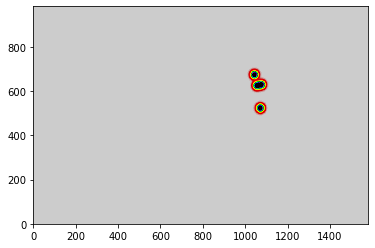

In [50]:
i = 4
print(np.max(SPC_temp[i, ...]))
plt.pcolormesh(gaussian_filter(SPC_temp[i, ...], 10), vmin=0, vmax=0.001, cmap=plt.cm.nipy_spectral_r)

In [15]:
subprocess.Popen("rm {}VALID*.npy".format(batch_dir), shell=True)

years = ['2018', '2019']

count = 0

for year in years:

    with h5py.File(save_dir+"NCAR500_y{}.hdf".format(year), 'r') as h5io:
        U10 = h5io['U10'][...] / 5.0 # normalization: factor of 0.6 m/s
        V10 = h5io['V10'][...] / 5.0
        UH03 = h5io['UH03'][...]
        
    # UH: gaussian filter with sigma=3km
    L = len(UH03)
    for i in range(L):
        UH03[i, ...] = gaussian_filter(UH03[i, ...], 1)
        
    # abs larger than 5.0 convert to +/- 5.0
    UH03[UH03>5.0] = 5.0
    U10[U10>5.0] = 5.0
    V10[V10>5.0] = 5.0
    
    UH03[UH03<0] = 0.0
    U10[U10<-5.0] = -5.0
    V10[V10<-5.0] = -5.0
    
    count = crop_batch(UH03, (U10, V10), 72, nonzero_thres, zero_def, batch_dir, prefix_name='VALID', prefix_number=count)

In [16]:
# data = np.load(batch_dir+'TRAIN_{}.npy'.format(3))
# plt.pcolormesh(data[..., 1])

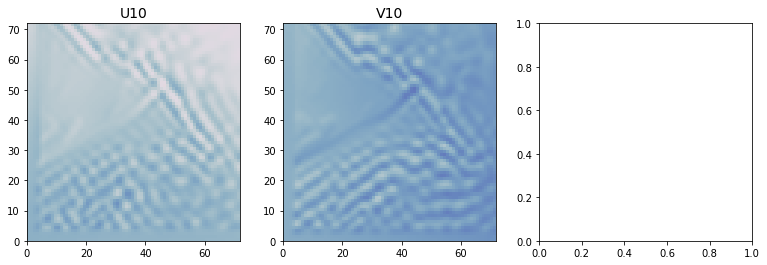

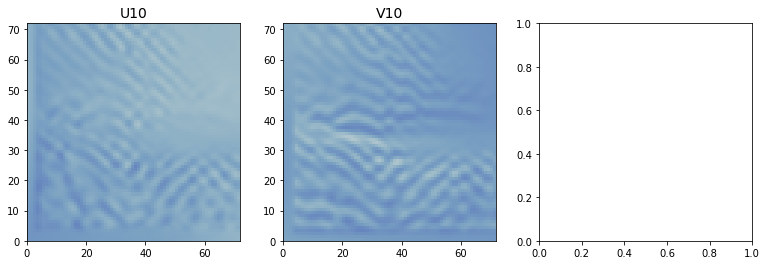

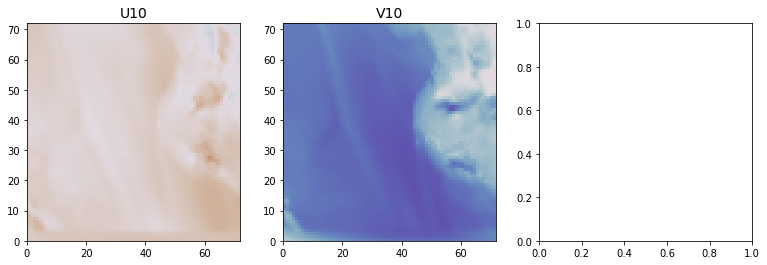

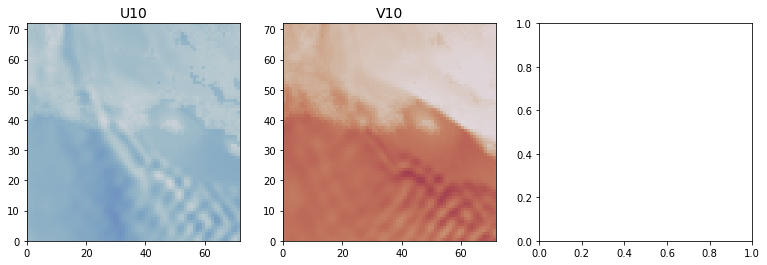

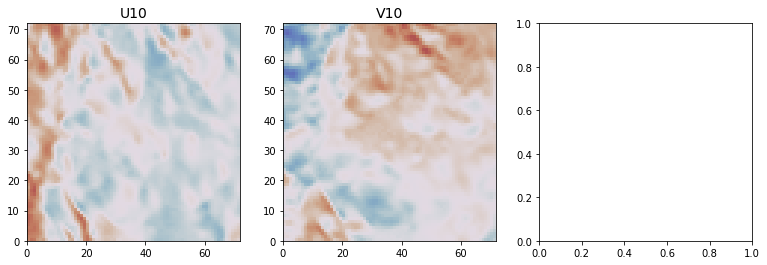

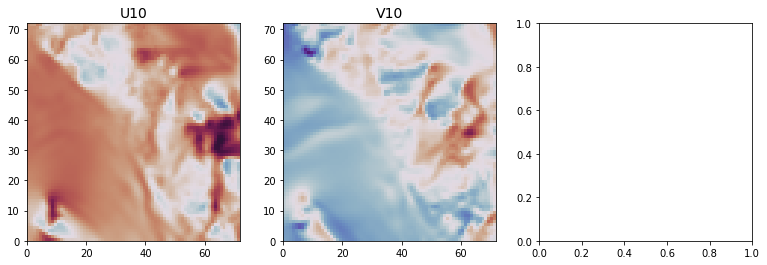

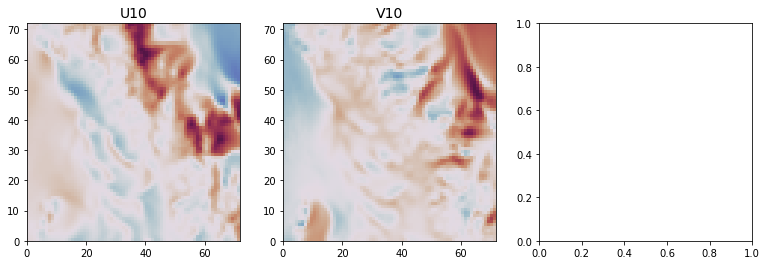

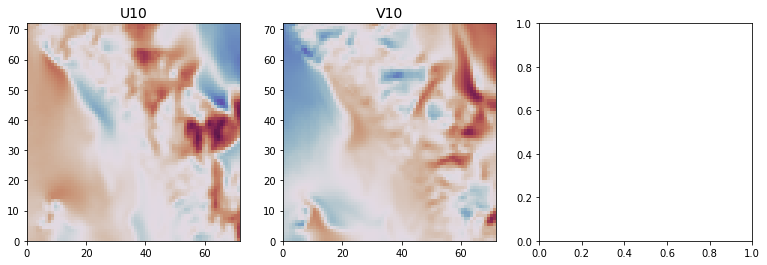

In [67]:
filenames = sorted(glob(batch_dir+'TRAIN*.npy'))

for i in range(0, 8, 1):
    data = np.load(filenames[i])
    
    plt.figure(figsize=(13, 4))
    ax1 = plt.subplot(131); ax2 = plt.subplot(132); ax3 = plt.subplot(133)
    ax1.pcolormesh(data[..., 0], vmin=-3, vmax=3, cmap=plt.cm.twilight_shifted); ax1.set_title('U10', fontsize=14)
    ax2.pcolormesh(data[..., 1], vmin=-3, vmax=3, cmap=plt.cm.twilight_shifted); ax2.set_title('V10', fontsize=14)
    #ax3.pcolormesh(data[..., 2], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r); ax3.set_title('UH03', fontsize=14)